# Decoding mouse from trial sequences

In [2]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [3]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,  LabelBinarizer
from sklearn.cluster import KMeans
import umap
from sklearn import mixture
import pickle
from scipy.stats import mode

# --Machine learning and statistics
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import entropy

# Get my functions
functions_path =  prefix + 'representation_learning_variability/Functions/'
os.chdir(functions_path)
from data_processing import save_and_log
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//4_analyses/5_clustering_analyses/'
os.chdir(functions_path)
from clustering_functions import GMM_neg_log_likelihood
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
# from postprocessing_functions import define_trial_types, bin_sequence, decoder

from one.api import ONE
one = ONE(mode='remote')

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/one/alf/files.py:10: FutureWarning: `one.alf.files` will be removed in version 3.0. Use `one.alf.path` instead.
  warnings.warn(


## Parameters

In [4]:
# Parameters
bin_size = 0.017
num_states = 2
threshold = 0.0
optimal_k = 4

save_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'

# LOAD DATA
data_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v5_15Jan2025/' + str(bin_size) + '/'
all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)

states_path =  prefix + 'representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'
wavelet_states_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/wavelet_transform_states/'

path_sets = [wavelet_states_path, states_path, states_path]


# Individual sessions

In [5]:
# Identify sessions available to process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    fit_id = str(mouse_name + session)
    whisker_filename = os.path.join(states_path, "most_likely_states" + 'whisker_me' + '_' + fit_id)
    licks_filename = os.path.join(states_path, "most_likely_states" + 'Lick count' + '_' + fit_id)
    wavelet_filename = os.path.join(wavelet_states_path, "most_likely_states_" + str(optimal_k) + '_' + fit_id)

    if os.path.exists(whisker_filename) and os.path.exists(licks_filename) and os.path.exists(wavelet_filename):
        sessions_to_process.append((mouse_name, session))

print(f"Found {len(sessions_to_process)} sessions to process.")

Found 215 sessions to process.


## Get sequences per trial epoch

In [6]:
results_path = prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/1_HMM_states/'
filename = str(results_path + 'epoch_sequences_10_03-11-2025')
all_sequences = pickle.load(open(filename, 'rb'))

In [7]:
design_df = all_sequences.pivot(index=['sample', 'trial_type', 'mouse_name'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
var_names = design_df.keys()[-4:]

In [8]:
df = design_df.copy()
df['feedback'] = df['trial_type'].str.split().str[:1].str.join('')
df['choice'] = df['trial_type'].str.split().str[3:4].str.join('')
df['block'] = df['trial_type'].str.split().str[2:3].str.join('')
df['contrast'] = df['trial_type'].str.split().str[1:2].str.join('')
df['side'] = df['choice'].copy()
df.loc[(df['feedback']=='correct') & (df['choice']=='right'), 'side'] = 'left'
df.loc[(df['feedback']=='correct') & (df['choice']=='left'), 'side'] = 'right'

df['session'] = df['sample'].str.split().str[:1].str.join('')
df['trial_id'] = df['sample'].str.split().str[1:2].str.join('')

## Get timing data

In [9]:
# Load old data to get ballistic trials
results_path = prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/'
filename = str(results_path + 'cluster_per_trial01-09-2025')
old_trial_data = pd.read_parquet(filename, engine='pyarrow')
old_trial_data['trial_id'] = old_trial_data['sample'].str.split().str[1:2].str.join('')
# old_trial_data = pd.DataFrame(old_trial_data.groupby(['session', 'trial_id'])['ballistic'].mean()).reset_index()

In [10]:
# Load preprocessed data
results_path = prefix + 'representation_learning_variability/Models/Sub-trial/3_postprocess_results/'
filename_states = str(results_path + 'states_trial_type02-28-2025')
filename_states = str(results_path + 'states_trial_type03-11-2025')
states_file = pd.read_parquet(filename_states, engine='pyarrow')

In [11]:
# Get timing info
vars = ['trial_id', 'session', 'mouse_name']

elongation = pd.DataFrame(states_file.groupby(vars)['elongation'].mean()).reset_index()
elongation['trial_id'] = elongation['trial_id'].astype(str)
response = pd.DataFrame(states_file.groupby(vars)['response'].mean()).reset_index()
response['trial_id'] = response['trial_id'].astype(str)
reaction = pd.DataFrame(states_file.groupby(vars)['reaction'].mean()).reset_index()
reaction['trial_id'] = reaction['trial_id'].astype(str)
ballistic = pd.DataFrame(old_trial_data.groupby(vars)['ballistic'].mean()).reset_index()
ballistic['trial_id'] = ballistic['trial_id'].astype(str)

In [12]:
# Merge

merged_df = df.merge(elongation, on=['session', 'trial_id', 'mouse_name'])
merged_df = merged_df.merge(response, on=['session', 'trial_id', 'mouse_name'])
merged_df = merged_df.merge(reaction, on=['session', 'trial_id', 'mouse_name'])
merged_df = merged_df.merge(ballistic, on=['session', 'trial_id', 'mouse_name'])

merged_df['contrast'] = merged_df['contrast'].astype(float)
merged_df['block'] = merged_df['block'].astype(float)

# Timing quantiles and choice
merged_df['response_qt'] = pd.qcut(merged_df['response'], 4, labels=False)/4
merged_df['elongation_qt'] = pd.qcut(merged_df['elongation'], 4, labels=False)/4

merged_df['choice'] = merged_df['trial_type'].str.split().str[3:4].str.join('')
merged_df.loc[merged_df['choice']=='left', 'choice'] = 0
merged_df.loc[merged_df['choice']=='right', 'choice'] = 1

merged_df.loc[merged_df['feedback']=='correct', 'feedback'] = 1
merged_df.loc[merged_df['feedback']=='incorrect', 'feedback'] = 0

In [13]:
del states_file

## Separate states per variable (one-hot encoding)

#### Use all epochs

In [14]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

sequences_choice = np.vstack(merged_df[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]

use_states = int(max(np.unique(use_sequences)))+1
timesteps = np.shape(use_sequences)[1]
binarized = np.zeros((np.shape(use_sequences)[0], timesteps*use_states))

for t in range(timesteps):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(use_states))
    encoded_arr = label_binarizer.transform(use_sequences[:, t])
    binarized[:, t*use_states:(t+1)*use_states] = encoded_arr
    # print('{0}'.format(encoded_arr))

### Add timing and choice info

In [15]:
new_columns = np.array(merged_df[['response_qt', 'response_qt', 'choice']]).astype(float)
new_columns = np.array(merged_df[['response_qt', 'response_qt']]).astype(float)

final_matrix = np.concatenate((binarized, new_columns), axis=1)

### One-hot encoding of trial type

In [16]:

type = pd.factorize(merged_df['trial_type'])[0]

label_binarizer = LabelBinarizer()
label_binarizer.fit(range(len(np.unique(type))))
encoded_arr = label_binarizer.transform(type)


In [17]:
final_matrix = np.concatenate((final_matrix, encoded_arr), axis=1)

([<matplotlib.axis.XTick at 0x7197746e8b50>,
 [Text(0, 0, '0'),
  Text(160, 0, '160'),
  Text(320, 0, '320'),
  Text(480, 0, '480'),
  Text(640, 0, '640')])

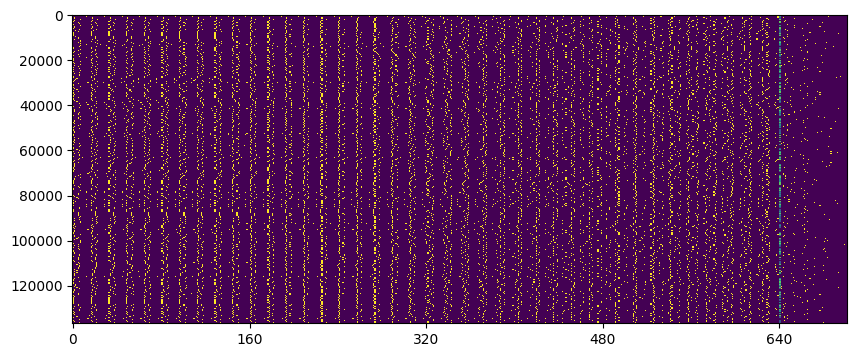

In [18]:
plt.figure(figsize=(10, 4))
plt.imshow(final_matrix, aspect='auto', cmap='viridis', interpolation='none')
plt.xticks(np.arange(0, np.shape(final_matrix)[1], 160), np.arange(0, np.shape(final_matrix)[1], 160))

In [19]:
mat = pd.DataFrame(final_matrix)
mat['mouse_number'] = pd.factorize(merged_df['mouse_name'])[0]


## Decode mouse

In [20]:
def plot_cm(decoding_result, trial_epochs, control=False):
    """
    PLOT RESULTS
    """

    # -- Confusion Matrix
    # labels = trial_epochs

    # Results on original model
    plt.rc('font', size=9) 
    plt.figure(figsize=[12.2, 10.2])
    hmap = sns.color_palette("mako", as_cmap=True)
    data = decoding_result.loc[decoding_result['shuffle'] == 0]
    sns.heatmap(data['confusion_matrix'].mean(), annot=False, square=True,
        yticklabels=trial_epochs, xticklabels=trial_epochs, 
        cmap= hmap, vmin=0, vmax=1, fmt=".2f") 

    # plt.xticks([.5, 1.5, 2.5, 3.5], trial_epochs)
    # plt.yticks([.5, 1.5, 2.5, 3.5], trial_epochs)
    plt.xticks(rotation = 90)
    plt.yticks(rotation = 0)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.savefig('full_cm.svg',dpi=500)
    plt.show()
    print('F1 results', data['f1'].mean())

    if control:
        # Results from shuffled model
        plt.rc('font', size=9) 
        plt.figure(figsize=[12.2, 10.2])
        data = decoding_result.loc[decoding_result['shuffle'] >0]
        sns.heatmap(data['confusion_matrix'].mean(), annot=False, square=True,
            yticklabels=trial_epochs, xticklabels=trial_epochs, 
            cmap= hmap, vmin=0, vmax=1, fmt=".2f")

        # plt.xticks([.5, 1.5, 2.5, 3.5], trial_epochs)
        # plt.yticks([.5, 1.5, 2.5, 3.5], trial_epochs)
        plt.xticks(rotation = 90)
        plt.yticks(rotation = 0)
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.show()
        print('F1 shuffled results',  data['f1'].mean())
    plt.tight_layout()

def plot_f1(decoding_result):
    # -- F1 score per model, original and shuffled
    data = decoding_result.copy()
    data['f1'] = data['f1'].astype(float)

    data.loc[data['shuffle'] >= 1, 'shuffle'] = 'Shuffled'
    data.loc[data['shuffle'] == 0, 'shuffle'] = 'Original'
    data = data.rename(columns={'shuffle': 'Dataset'})

    plt.rc('font', size=12) 
    plt.figure(figsize=[4.5, 4])
    sns.boxplot(y='f1', x='Dataset', data=data, color='grey') 
    sns.swarmplot(y='f1', x='Dataset', data=data, color='black', dodge=True, alpha=0.7, size=3)
    plt.ylim([0,1])
    plt.ylabel('Accuracy score (F1)')
    plt.legend(bbox_to_anchor=(1.05, 1))
    sns.despine(top=True, right=True)
    #plt.savefig('violin.svg',dpi=500)
    

In [21]:
shufflings = 1  #shuffling
model = GaussianNB()
# model = RandomForestClassifier(max_depth=2, random_state=0)
model = RandomForestClassifier(random_state=42)

In [22]:
var = 'mouse_number'    
use_mat = mat.copy() # test using all mice

In [23]:
"""
RUN MODEL
"""

# Generate random states for each iteration with a fixed seed
# Loop over iterations of random draws of mice
# Create empty dataframes to save results
decoding_result = pd.DataFrame(columns=['shuffle', 'f1', 'confusion_matrix'])

# Decoding function with 10-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=0)
use_mat = mat.copy() # test using all mice

# Find minimum number of samples per label
labels = np.array(use_mat[var])
labels_nr = np.arange(len(use_mat[var]))
min_freq = np.min(use_mat[var].value_counts())

# Randomly select N mice from each quartile to equalize classes
use_index = np.empty(0, dtype=int)
for j, epoch in enumerate(np.unique(labels)):
    use_index = np.concatenate([use_index, np.random.choice(labels_nr[labels == epoch],
                                                            min_freq, replace=False)])

new_mat = use_mat.iloc[use_index].reset_index().drop(columns=['index']).copy()
        
# -- ORIGINAL DATASET

dec_result = pd.DataFrame(columns=['shuffle', 'f1', 'confusion_matrix'])
y_pred = np.zeros(len(new_mat), dtype=int) 
exog = new_mat[new_mat.columns.difference([var])]
endog = new_mat.loc[:, var].copy()
# endog[:] = replace_func(endog)

for train_index, test_index in kf.split(new_mat):
    model.fit(exog.iloc[train_index], endog.iloc[train_index].astype(int))
    # model.fit(exog.iloc[train_index], endog.iloc[train_index])
    y_pred[test_index] = model.predict(exog.iloc[test_index])

# Calculate f1 score and confusion matrix
f1 = f1_score(endog.astype(int), y_pred.astype('int'), average='micro')
cm = confusion_matrix(endog.astype(int), y_pred.astype('int'), normalize='true')

# Save results
dec_result.loc[0, 'f1'] = f1
dec_result.loc[0, 'confusion_matrix'] = cm
dec_result.loc[0, 'shuffle'] = 0

decoding_result = pd.concat([decoding_result, dec_result])

# -- SHUFFLED DATASET 
shuffle_result = pd.DataFrame(columns=['shuffle', 'f1', 'confusion_matrix'])
for s in range(shufflings):
    if np.mod(s+1, 10) == 0:
        print('Shuffling %d of %d' % (s+1, shufflings))   

    shuffle_y_pred = np.zeros(len(new_mat), dtype=int) 
    shuffle_endog = endog.copy()
    np.random.shuffle(shuffle_endog.values)

    for train_index, test_index in kf.split(new_mat):
        model.fit(exog.iloc[train_index], list(shuffle_endog.iloc[train_index].astype(int)))
        shuffle_y_pred[test_index] = model.predict(exog.iloc[test_index])   

    shuffle_f1 = f1_score(shuffle_endog.astype(int), shuffle_y_pred.astype('int'), average='micro')
    shuffle_cm = confusion_matrix(shuffle_endog.astype(int), shuffle_y_pred.astype('int'), normalize='true')

    # SAVE
    shuffle_result.loc[s, 'f1'] = shuffle_f1
    shuffle_result.loc[s, 'confusion_matrix'] = shuffle_cm
    shuffle_result.loc[s, 'shuffle'] = s + 1

decoding_result = pd.concat([decoding_result, shuffle_result])

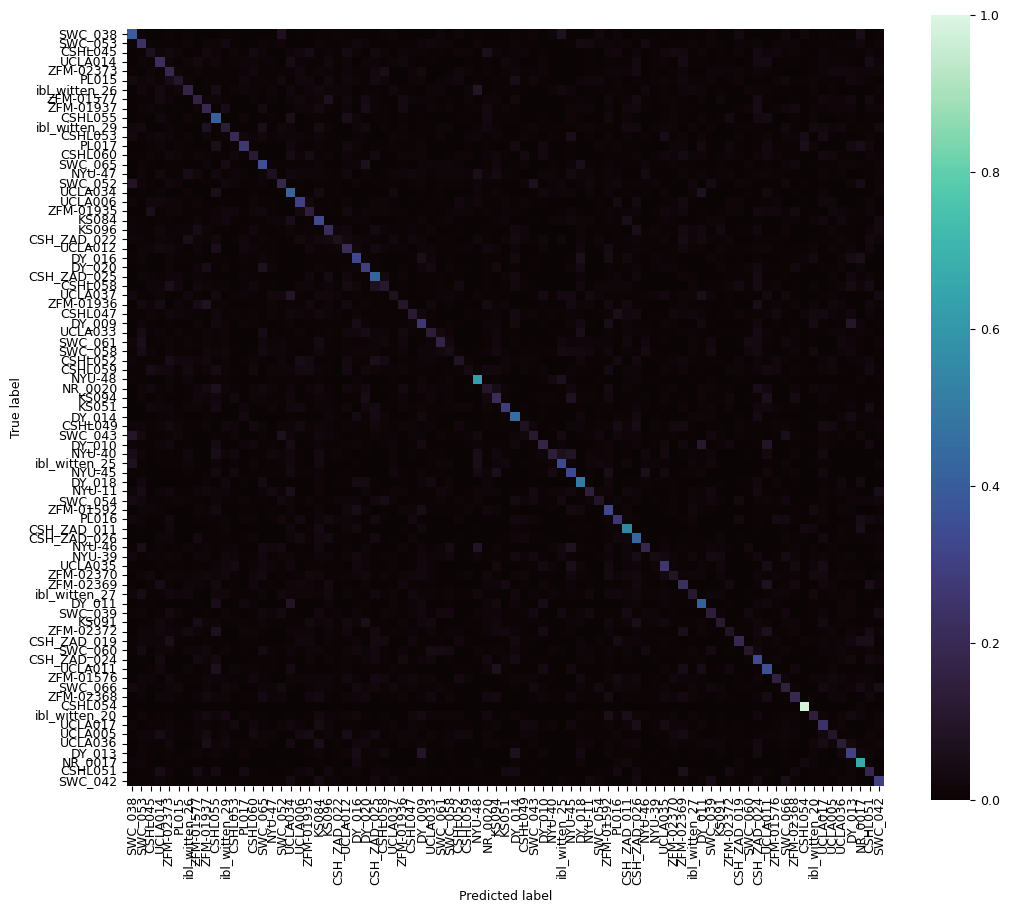

F1 results 0.22872490811422108


/tmp/ipykernel_16908/3017111927.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1))


<Figure size 640x480 with 0 Axes>

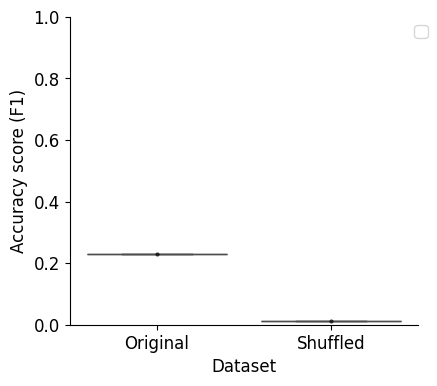

In [24]:
plot_cm(decoding_result, merged_df['mouse_name'].unique(), control=False)
plot_f1(decoding_result)

## Cluster based on error 

In [25]:
trials = pd.DataFrame(use_sequences)
trials['mouse_name'] = merged_df['mouse_name']
trials['mouse_number'] = pd.factorize(merged_df['mouse_name'])[0]

In [26]:
distance_matrix = decoding_result.loc[decoding_result['shuffle'] == 0, 'confusion_matrix'].mean()

In [27]:
from scipy.spatial.distance import pdist, squareform

# Use cosine distance (1 - cosine similarity)
C_sym = (distance_matrix + distance_matrix.T) / 2
dist_matrix = squareform(pdist(C_sym, metric='cosine'))

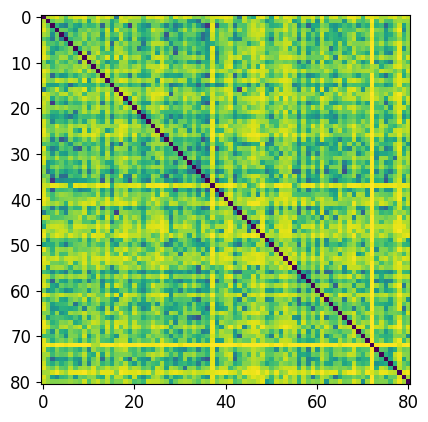

In [28]:
plt.imshow(dist_matrix)

/tmp/ipykernel_16908/1040872069.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist_matrix, method='average')  # You can also try 'complete', 'ward', etc.


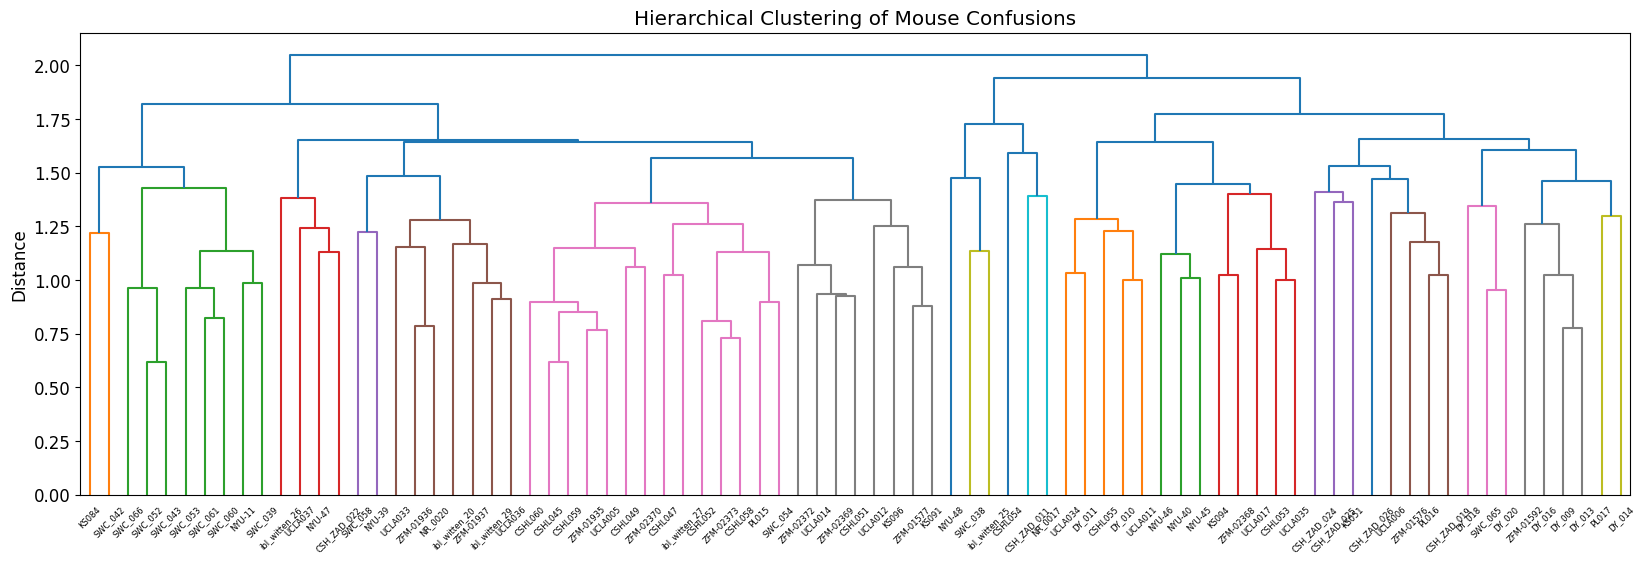

In [29]:
from scipy.cluster.hierarchy import linkage, dendrogram
# Perform clustering
Z = linkage(dist_matrix, method='average')  # You can also try 'complete', 'ward', etc.

# Plot dendrogram
plt.figure(figsize=(20, 6))
dendrogram(Z, labels=trials['mouse_name'].unique(), leaf_rotation=45)
plt.title("Hierarchical Clustering of Mouse Confusions")
plt.ylabel("Distance")
plt.show()

In [30]:
from scipy.cluster.hierarchy import fcluster
k = 4
clusters = fcluster(Z, t=k, criterion='maxclust')
# design_df['session_cluster'] = clusters 

(array([10.,  0.,  0., 35.,  0.,  0.,  6.,  0.,  0., 30.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

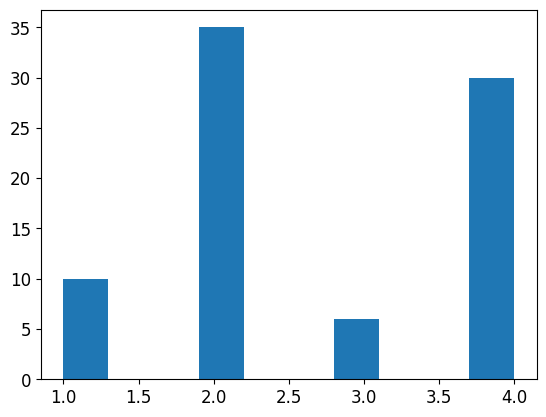

In [31]:
plt.hist(clusters)

# Visualize clusters

In [32]:
diagonal = pd.DataFrame(np.diag(decoding_result.loc[decoding_result['shuffle']==0, 'confusion_matrix'][0]))
diagonal['mouse_number'] = list(trials['mouse_number'].drop_duplicates())
diagonal = diagonal.rename(columns={0: 'accuracy'})

cluster_df = pd.DataFrame(clusters)
cluster_df['mouse_number'] = list(trials['mouse_number'].drop_duplicates())
cluster_df = cluster_df.rename(columns={0: 'mouse_cluster'})

trials = trials.merge(cluster_df, on=['mouse_number'])

In [33]:
wheel_mapping = {0:0, 1:1, 2:2, 3:3,
                 4:0, 5:1, 6:2, 7:3,
                 8:0, 9:1, 10:2, 11:3,
                 12:0, 13:1, 14:2, 15:3}
whisker_mapping = {0:0, 1:0, 2:0, 3:0,
                 4:1, 5:1, 6:1, 7:1,
                 8:0, 9:0, 10:0, 11:0,
                 12:1, 13:1, 14:1, 15:1}
lick_mapping = {0:0, 1:0, 2:0, 3:0,
                 4:0, 5:0, 6:0, 7:0,
                 8:1, 9:1, 10:1, 11:1,
                 12:1, 13:1, 14:1, 15:1}
replace_wheel = np.vectorize(wheel_mapping.get)
# wheel_states = replace_wheel(use_sequences)
replace_whisker = np.vectorize(whisker_mapping.get)
# whisker_states = replace_whisker(use_sequences)
replace_lick = np.vectorize(lick_mapping.get)

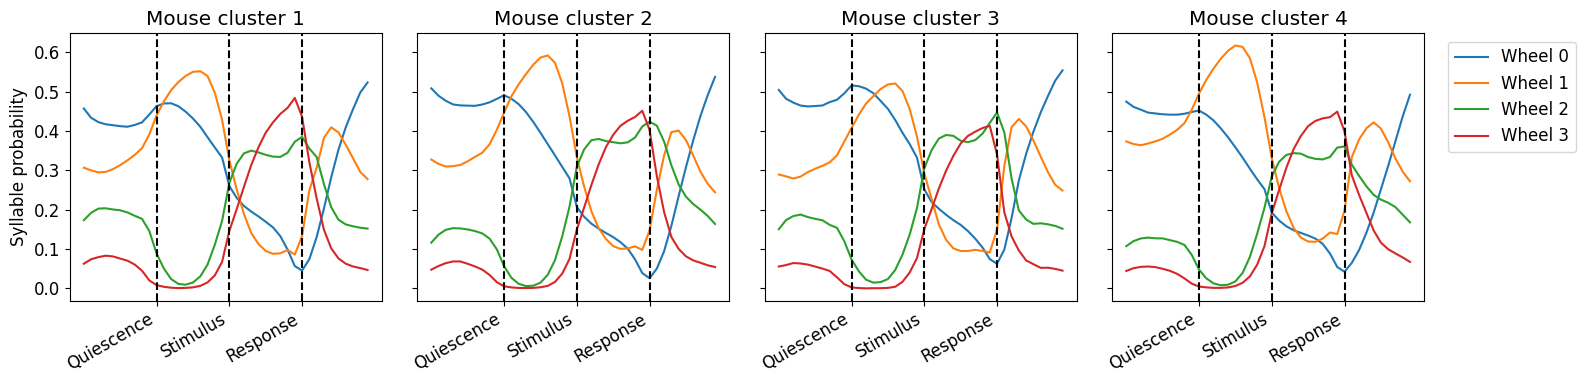

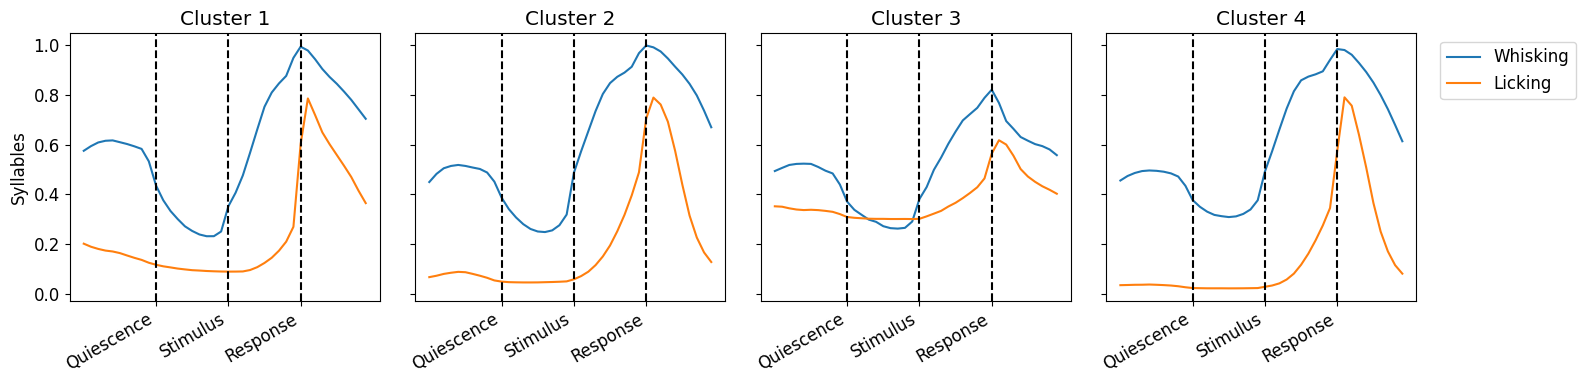

In [35]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

color = sns.color_palette("Set2", 7)
fig, axs = plt.subplots(1, np.max(clusters), sharex=True, sharey=True, figsize=(16, 4))


for c, cluster in enumerate(np.arange(1, np.max(clusters)+1)):
    
    cluster_data = trials.loc[trials['mouse_cluster']==cluster]
    use_sequences = np.array(cluster_data.drop(columns=['mouse_name', 'mouse_number', 'mouse_cluster']))
    # sequences_choice = np.vstack(cluster_data[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
    # use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]
    
    replace_whisker = np.vectorize(whisker_mapping.get)
    whisker_states = replace_whisker(use_sequences)
    replace_wheel = np.vectorize(wheel_mapping.get)
    wheel_states = replace_wheel(use_sequences)    
    replace_lick = np.vectorize(lick_mapping.get)
    lick_states = replace_lick(use_sequences)
    
    whisker_count = np.zeros((1, 40))
    lick_count = np.zeros((1, 40))
    wheel_count = np.zeros((4, 40))

    for b, bin in enumerate(range(40)):
        # counts, bins = np.histogram(use_sequences[:, b], range=(0,15), bins=16)
        whisker_count[0, b] = np.sum(whisker_states[:, b]==1)/len(whisker_states[:, b])
        lick_count[0, b] = np.sum(lick_states[:, b]==1)/len(lick_states[:, b])
        wheel_count[0, b] = np.sum(wheel_states[:, b]==1)/len(wheel_states[:, b])
        wheel_count[1, b] = np.sum(wheel_states[:, b]==2)/len(wheel_states[:, b])
        wheel_count[2, b] = np.sum(wheel_states[:, b]==3)/len(wheel_states[:, b])
        wheel_count[3, b] = np.sum(wheel_states[:, b]==0)/len(wheel_states[:, b])
    
    all_stacked = np.vstack([wheel_count, whisker_count, lick_count])
    # all_stacked = np.vstack([wheel_count])

    # cmap_value_1 = create_shaded_cmap(colors[q], name='cmap_value_1')
    # image = axs[c].imshow(all_stacked, cmap=cmap_value_1, aspect='auto')
    axs[c].plot(all_stacked[0:4, :].T, label=['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3'])
    # image = axs[q].imshow(all_stacked, cmap='Greys', aspect='auto')
    # fig.colorbar(image, ax=axs[q], location='right', anchor=(0, 0.3))
    # axs[q].set_yticks(np.arange(0, 6, 1), ['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3', 'Whisking', 'Licking'])
    # axs[c].set_yticks(np.arange(0, 4, 1), ['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3'])
    axs[c].axvline(x=10, color='k', linestyle='--')
    axs[c].axvline(x=20, color='k', linestyle='--')
    axs[c].axvline(x=30, color='k', linestyle='--')

    axs[c].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    # axs[c].set_xlabel('Time in epoch')
    axs[c].set_title('Mouse cluster ' +str(cluster))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
axs[0].set_ylabel('Syllable probability')
plt.tight_layout()
plt.show()


fig, axs = plt.subplots(1, np.max(clusters), sharex=True, sharey=True, figsize=(16, 4))

for c, cluster in enumerate(np.arange(1, np.max(clusters)+1)):
    
    cluster_data = trials.loc[trials['mouse_cluster']==cluster]
    use_sequences = np.array(cluster_data.drop(columns=['mouse_name', 'mouse_number', 'mouse_cluster']))
    
    replace_whisker = np.vectorize(whisker_mapping.get)
    whisker_states = replace_whisker(use_sequences)
    replace_wheel = np.vectorize(wheel_mapping.get)
    wheel_states = replace_wheel(use_sequences)    
    replace_lick = np.vectorize(lick_mapping.get)
    lick_states = replace_lick(use_sequences)
    
    whisker_count = np.zeros((1, 40))
    lick_count = np.zeros((1, 40))
    wheel_count = np.zeros((4, 40))

    for b, bin in enumerate(range(40)):
        # counts, bins = np.histogram(use_sequences[:, b], range=(0,15), bins=16)
        whisker_count[0, b] = np.sum(whisker_states[:, b]==1)/len(whisker_states[:, b])
        lick_count[0, b] = np.sum(lick_states[:, b]==1)/len(lick_states[:, b])
        wheel_count[0, b] = np.sum(wheel_states[:, b]==1)/len(wheel_states[:, b])
        wheel_count[1, b] = np.sum(wheel_states[:, b]==2)/len(wheel_states[:, b])
        wheel_count[2, b] = np.sum(wheel_states[:, b]==3)/len(wheel_states[:, b])
        wheel_count[3, b] = np.sum(wheel_states[:, b]==0)/len(wheel_states[:, b])
    
    all_stacked = np.vstack([wheel_count, whisker_count, lick_count])

    axs[c].plot(all_stacked[4:6, :].T, label=['Whisking', 'Licking'])
    axs[c].axvline(x=10, color='k', linestyle='--')
    axs[c].axvline(x=20, color='k', linestyle='--')
    axs[c].axvline(x=30, color='k', linestyle='--')

    axs[c].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    axs[c].set_title('Cluster ' +str(cluster))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
axs[0].set_ylabel('Syllables')
plt.tight_layout()
plt.show()

## Analyze entropy across trial per animal

In [ ]:
trials = pd.DataFrame(binarized)
trials['mouse_name'] = merged_df['mouse_name']
trials['mouse_number'] = pd.factorize(merged_df['mouse_name'])[0]
diagonal = pd.DataFrame(np.diag(decoding_result.loc[decoding_result['shuffle']==0, 'confusion_matrix'][0]))
diagonal['mouse_number'] = list(trials['mouse_number'].drop_duplicates())
diagonal = diagonal.rename(columns={0: 'accuracy'})
trials = trials.merge(diagonal, on=['mouse_number'])

Text(0.5, 0, 'Decoding accuracy')

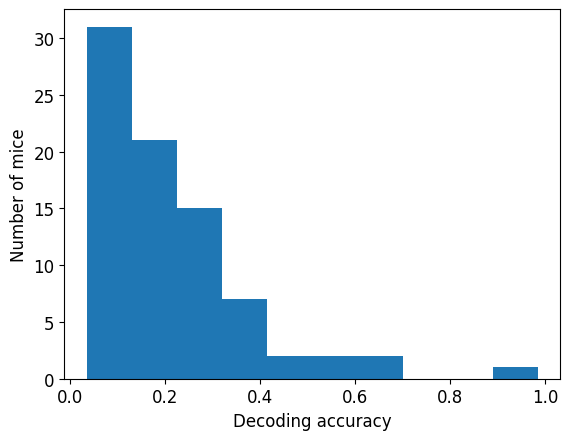

In [206]:
plt.hist(diagonal['accuracy'])
plt.ylabel('Number of mice')
plt.xlabel('Decoding accuracy')

In [186]:
entropy_df = pd.DataFrame(columns=['mouse_name',  'accuracy', 'bin', 'entropy'])

for m, mouse in enumerate(trials['mouse_name'].unique()):
    
    use_df = trials.loc[trials['mouse_name']==mouse]
    state_probs = np.mean(use_df.drop(columns=['mouse_name', 'mouse_number', 'accuracy']), axis=0)
    
    mouse_entropy = pd.DataFrame(columns=['mouse_name', 'accuracy', 'bin', 'entropy'], index=range(timesteps))
    mouse_entropy['mouse_name'] = mouse
    mouse_entropy['accuracy'] = list(use_df['accuracy'])[0]
    
    for t in range(timesteps):
        # label_binarizer = LabelBinarizer()
        # label_binarizer.fit(range(use_states))
        # encoded_arr = label_binarizer.transform(use_sequences[:, t])
        bin_data = state_probs[t*16:(t+1)*16]
        ent = entropy(bin_data)/np.log(16)
        mouse_entropy['entropy'][t] = ent
        mouse_entropy['bin'][t] = t
        
    entropy_df = pd.concat([entropy_df, mouse_entropy])
        
    

/tmp/ipykernel_19502/2226901285.py:18: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  mouse_entropy['entropy'][t] = ent
/tmp/ipykernel_19502/2226901285.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [210]:
entropy_df['accuracy_type'] = entropy_df['accuracy']
entropy_df.loc[entropy_df['accuracy_type']<.05, 'accuracy_type'] = 0
entropy_df.loc[entropy_df['accuracy_type']>.3, 'accuracy_type'] = 2
entropy_df.loc[(entropy_df['accuracy_type']>.05) &
               (entropy_df['accuracy_type']<.3), 'accuracy_type'] = 1



Text(0.5, 0, 'Trial events')

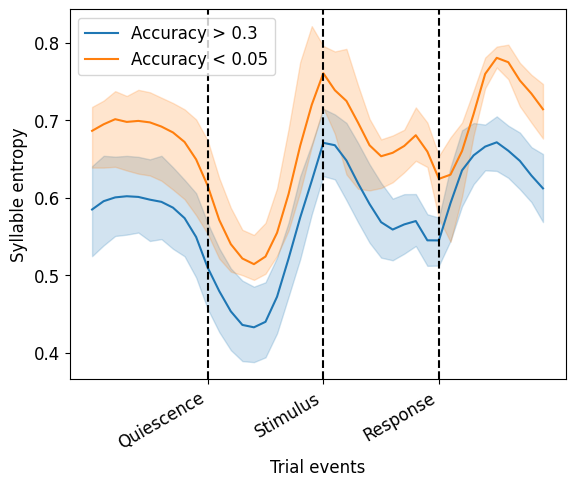

In [220]:
sns.lineplot(x='bin', y='entropy', data=entropy_df.loc[entropy_df['accuracy']>.3], label='Accuracy > 0.3')
# sns.lineplot(x='bin', y='entropy', data=entropy_df.loc[(entropy_df['accuracy']>.05) &
#                                                        (entropy_df['accuracy']<.3)])
sns.lineplot(x='bin', y='entropy', data=entropy_df.loc[entropy_df['accuracy']<.05], label='Accuracy < 0.05')


plt.axvline(x=10, color='k', linestyle='--')
plt.axvline(x=20, color='k', linestyle='--')
plt.axvline(x=30, color='k', linestyle='--')

plt.xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
plt.ylabel('Syllable entropy')
plt.xlabel('Trial events')

## Vizualize results

In [216]:
wheel_mapping = {0:0, 1:1, 2:2, 3:3,
                 4:0, 5:1, 6:2, 7:3,
                 8:0, 9:1, 10:2, 11:3,
                 12:0, 13:1, 14:2, 15:3}
whisker_mapping = {0:0, 1:0, 2:0, 3:0,
                 4:1, 5:1, 6:1, 7:1,
                 8:0, 9:0, 10:0, 11:0,
                 12:1, 13:1, 14:1, 15:1}
lick_mapping = {0:0, 1:0, 2:0, 3:0,
                 4:0, 5:0, 6:0, 7:0,
                 8:1, 9:1, 10:1, 11:1,
                 12:1, 13:1, 14:1, 15:1}
replace_wheel = np.vectorize(wheel_mapping.get)
# wheel_states = replace_wheel(use_sequences)
replace_whisker = np.vectorize(whisker_mapping.get)
# whisker_states = replace_whisker(use_sequences)
replace_lick = np.vectorize(lick_mapping.get)

In [ ]:
# select mice with very good decoding or bad

/tmp/ipykernel_19502/2601245174.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


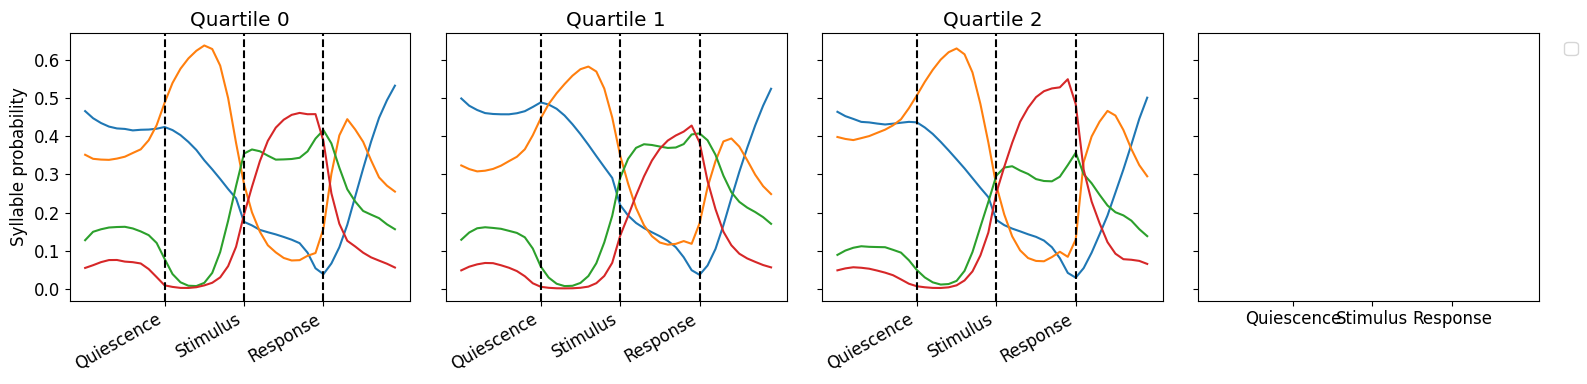

In [217]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

color = sns.color_palette("Set2", 7)
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 4))

use_data = trial_clusters.merge(entropy_df[['mouse_name', 'accuracy_type']].drop_duplicates(), on=['mouse_name'])


for q, quartile in enumerate([0, 1, 2]):
    cluster_data = use_data.loc[use_data['accuracy_type']==quartile]
    sequences_choice = np.vstack(cluster_data[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
    use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]
    
    replace_whisker = np.vectorize(whisker_mapping.get)
    whisker_states = replace_whisker(use_sequences)
    replace_wheel = np.vectorize(wheel_mapping.get)
    wheel_states = replace_wheel(use_sequences)    
    replace_lick = np.vectorize(lick_mapping.get)
    lick_states = replace_lick(use_sequences)
    
    whisker_count = np.zeros((1, 40))
    lick_count = np.zeros((1, 40))
    wheel_count = np.zeros((4, 40))

    for b, bin in enumerate(range(40)):
        # counts, bins = np.histogram(use_sequences[:, b], range=(0,15), bins=16)
        whisker_count[0, b] = np.sum(whisker_states[:, b]==1)/len(whisker_states[:, b])
        lick_count[0, b] = np.sum(lick_states[:, b]==1)/len(lick_states[:, b])
        wheel_count[0, b] = np.sum(wheel_states[:, b]==1)/len(wheel_states[:, b])
        wheel_count[1, b] = np.sum(wheel_states[:, b]==2)/len(wheel_states[:, b])
        wheel_count[2, b] = np.sum(wheel_states[:, b]==3)/len(wheel_states[:, b])
        wheel_count[3, b] = np.sum(wheel_states[:, b]==0)/len(wheel_states[:, b])
    
    all_stacked = np.vstack([wheel_count, whisker_count, lick_count])
    # all_stacked = np.vstack([wheel_count])

    # cmap_value_1 = create_shaded_cmap(colors[q], name='cmap_value_1')
    # image = axs[c].imshow(all_stacked, cmap=cmap_value_1, aspect='auto')
    axs[q].plot(all_stacked[0:4, :].T, label=['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3'])
    # image = axs[q].imshow(all_stacked, cmap='Greys', aspect='auto')
    # fig.colorbar(image, ax=axs[q], location='right', anchor=(0, 0.3))
    # axs[q].set_yticks(np.arange(0, 6, 1), ['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3', 'Whisking', 'Licking'])
    # axs[c].set_yticks(np.arange(0, 4, 1), ['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3'])
    axs[q].axvline(x=10, color='k', linestyle='--')
    axs[q].axvline(x=20, color='k', linestyle='--')
    axs[q].axvline(x=30, color='k', linestyle='--')

    axs[q].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    # axs[c].set_xlabel('Time in epoch')
    axs[q].set_title('Quartile ' +str(quartile))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
axs[0].set_ylabel('Syllable probability')
plt.tight_layout()
plt.show()

/tmp/ipykernel_19502/1841012585.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


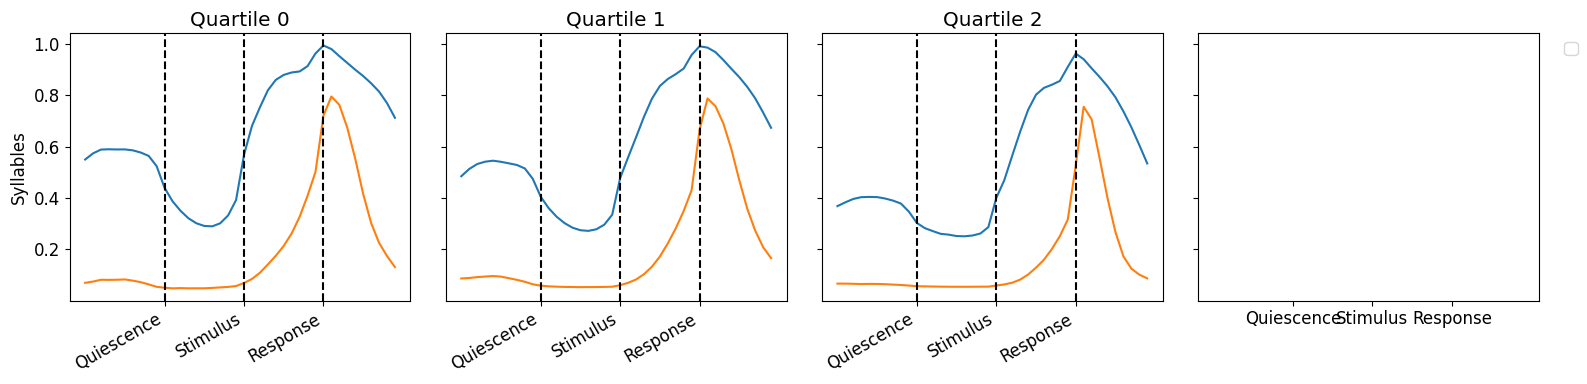

In [218]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

color = sns.color_palette("Set2", 7)
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 4))

use_data = trial_clusters.merge(entropy_df[['mouse_name', 'accuracy_type']].drop_duplicates(), on=['mouse_name'])


for q, quartile in enumerate([0, 1, 2]):
    
    cluster_data = use_data.loc[use_data['accuracy_type']==quartile]
    sequences_choice = np.vstack(cluster_data[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
    use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]
    
    replace_whisker = np.vectorize(whisker_mapping.get)
    whisker_states = replace_whisker(use_sequences)
    replace_wheel = np.vectorize(wheel_mapping.get)
    wheel_states = replace_wheel(use_sequences)    
    replace_lick = np.vectorize(lick_mapping.get)
    lick_states = replace_lick(use_sequences)
    
    whisker_count = np.zeros((1, 40))
    lick_count = np.zeros((1, 40))
    wheel_count = np.zeros((4, 40))

    for b, bin in enumerate(range(40)):
        # counts, bins = np.histogram(use_sequences[:, b], range=(0,15), bins=16)
        whisker_count[0, b] = np.sum(whisker_states[:, b]==1)/len(whisker_states[:, b])
        lick_count[0, b] = np.sum(lick_states[:, b]==1)/len(lick_states[:, b])
        wheel_count[0, b] = np.sum(wheel_states[:, b]==1)/len(wheel_states[:, b])
        wheel_count[1, b] = np.sum(wheel_states[:, b]==2)/len(wheel_states[:, b])
        wheel_count[2, b] = np.sum(wheel_states[:, b]==3)/len(wheel_states[:, b])
        wheel_count[3, b] = np.sum(wheel_states[:, b]==0)/len(wheel_states[:, b])
    
    all_stacked = np.vstack([wheel_count, whisker_count, lick_count])
    # all_stacked = np.vstack([wheel_count])

    # cmap_value_1 = create_shaded_cmap(colors[q], name='cmap_value_1')
    # image = axs[c].imshow(all_stacked, cmap=cmap_value_1, aspect='auto')
    axs[q].plot(all_stacked[4:6, :].T, label=['Whisking', 'Licking'])
    # image = axs[q].imshow(all_stacked, cmap='Greys', aspect='auto')
    # fig.colorbar(image, ax=axs[q], location='right', anchor=(0, 0.3))
    # axs[q].set_yticks(np.arange(0, 6, 1), ['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3', 'Whisking', 'Licking'])
    # axs[c].set_yticks(np.arange(0, 4, 1), ['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3'])
    axs[q].axvline(x=10, color='k', linestyle='--')
    axs[q].axvline(x=20, color='k', linestyle='--')
    axs[q].axvline(x=30, color='k', linestyle='--')

    axs[q].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    # axs[c].set_xlabel('Time in epoch')
    axs[q].set_title('Quartile ' +str(quartile))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
axs[0].set_ylabel('Syllables')
plt.tight_layout()
plt.show()